<a href="https://colab.research.google.com/github/divypandya/OpenCV-with-Python-Course/blob/master/Bubble_Sheet_MCQ_Scanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import imutils
import cv2
from google.colab.patches import cv2_imshow

# path to data used
args = {'input' : 'drive/My Drive/Colab Notebooks/CV Tutorials/images/example_test.png',
       'input2' : 'drive/My Drive/Colab Notebooks/CV Tutorials/images/test_01.png',
       'input3' : 'drive/My Drive/Colab Notebooks/CV Tutorials/images/test_02.png',
       'input4' : 'drive/My Drive/Colab Notebooks/CV Tutorials/images/test_03.png',
       'input5' : 'drive/My Drive/Colab Notebooks/CV Tutorials/images/test_04.png',
       'input6' : 'drive/My Drive/Colab Notebooks/CV Tutorials/images/test_05.png'
       }

# define the answer key which maps the question number
# to the correct answer
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

**Getting Bird Eye View of exam**


---



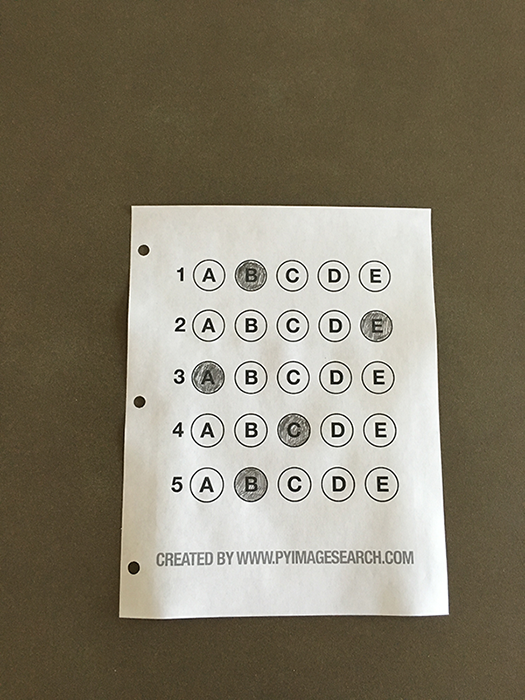

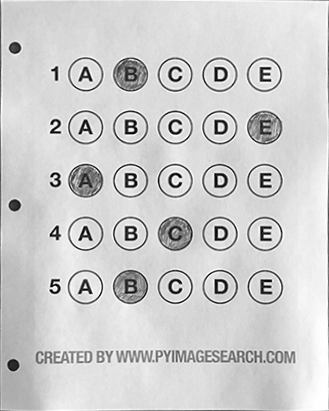

In [0]:
# load the image, convert it to grayscale, blur it
# slightly, then find edges
image = cv2.imread(args['input2'])
cv2_imshow(image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5,5), 0)
edged = cv2.Canny(blurred, 75, 200)

# find contours in the edge map, then initialize
# the contour that corresponds to the document
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
                       cv2.CHAIN_APPROX_SIMPLE
                       )
cnts = imutils.grab_contours(cnts)
docCnt = None

# ensure that at least one contour was found
if len(cnts) > 0:
    # sort the contours according to their size in
	# descending order
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)
    
    # loop over the sorted contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        
        # if our approximated contour has four points,
		# then we can assume we have found the paper
        if len(approx) == 4:
            docCnt = approx
            break
            

# apply a four point perspective transform to both the
# original image and grayscale image to obtain a top-down
# birds eye view of the paper
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))
cv2_imshow(warped)

**Grading the exam**


---



In [0]:
# apply Otsu's thresholding method to binarize the warped
# piece of paper
thresh = cv2.threshold(warped, 0, 255,
                       cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU 
                      )[1]

In [0]:
# find contours in the thresholded image, then initialize
# the list of contours that correspond to questions
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                       cv2.CHAIN_APPROX_SIMPLE
                       )
cnts = imutils.grab_contours(cnts)
questionCnts = []

# loop over the contours
for c in cnts:
    # compute the bounding box of the contour, then use the
	# bounding box to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    
    # in order to label the contour as a question, region
	# should be sufficiently wide, sufficiently tall, and
	# have an aspect ratio approximately equal to 1
    if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
        questionCnts.append(c)
        

In [0]:
# sort the question contours top-to-bottom, then initialize
# the total number of correct answers
questionCnts = contours.sort_contours(questionCnts,
                                     method = 'top-to-bottom'
                                     )[0]
correct = 0

# sort the question contours top-to-bottom, then initialize
# the total number of correct answers
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
    # sort the contours for the current question from
	# left to right, then initialize the index of the
	# bubbled answer
    cnts = contours.sort_contours(questionCnts[i : i + 5])[0]
    bubbled = None
    
    # loop over the sorted contours
    for (j, c) in enumerate(cnts):
        # construct a mask that reveals only the current
		# "bubble" for the question
        mask = np.zeros(thresh.shape, dtype = 'uint8')
        cv2.drawContours(mask, [c], -1, 255, -1)
        
        # apply the mask to the thresholded image, then
		# count the number of non-zero pixels in the
		# bubble area
        mask = cv2.bitwise_and(thresh, thresh, mask = mask)
        total = cv2.countNonZero(mask)
        
        # if the current total has a larger number of total
		# non-zero pixels, then we are examining the currently
		# bubbled-in answer
        if bubbled == None or total > bubbled[0]:
            bubbled = (total, j)
            
    # initialize the contour color and the index of the
	# *correct* answer
    color = (0, 0, 255)
    k = ANSWER_KEY[q]
    
    # check to see if the bubbled answer is correct
    if k == bubbled[1]:
        color = (0, 255, 0)
        correct+=1
        
    # draw the outline of the correct answer on the test
    cv2.drawContours(paper, [cnts[k]], -1, color, 3)

[INFO] score 80.00%


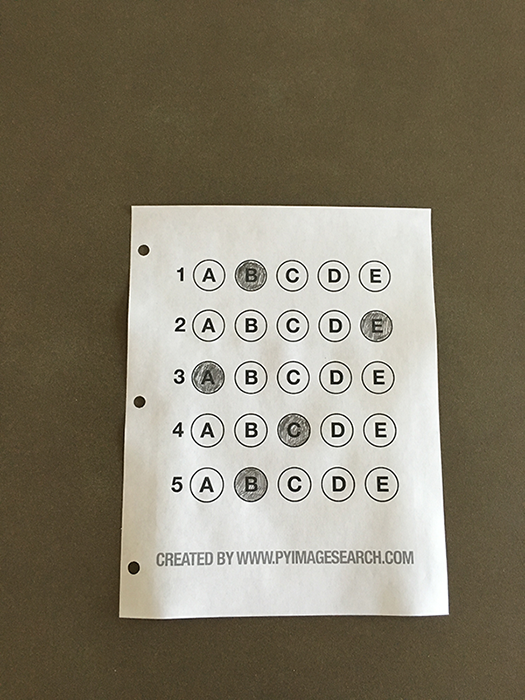

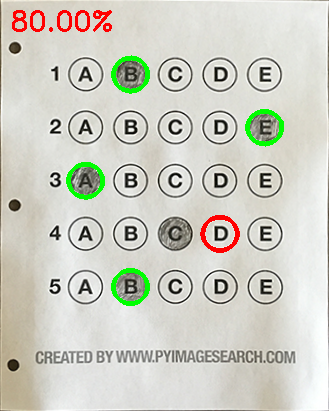

In [0]:
# grab the test taker
score = (correct / 5.0) * 100
print('[INFO] score {:.2f}%'.format(score))
cv2.putText(paper, '{:.2f}%'.format(score), (10, 30),
           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2
           )
cv2_imshow(image)
cv2_imshow(paper)